In [77]:
import torch
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from pylab import rcParams
from tqdm import tqdm
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

# template
RANDOM_SEED = 40
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['figure.figsize'] = 22, 10
register_matplotlib_converters()

DATA = {
    'confirmed': 'drive/My Drive/coronavirusdatasets/time_series_covid19_confirmed_global.csv',
    'death': 'drive/My Drive/coronavirusdatasets/time_series_covid19_deaths_global.csv',
    'recovered': 'drive/My Drive/coronavirusdatasets/time_series_covid19_recovered_global.csv'
}


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [78]:
confirmed_df = pd.read_csv(DATA['confirmed'])
death_df = pd.read_csv(DATA['death'])
recovered_df = pd.read_csv(DATA['recovered'])

confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,37424,37431,37551,37596,37599,37599,37599,37856,37894,37953,37999,38054,38070,38113,38129,38140,38143,38162,38165,38196,38243,38288,38304,38324,38398,38494,38520,38544,38572,38606,38641,38716,38772,38815,38855,38872,38883,38919,39044,39074
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6971,7117,7260,7380,7499,7654,7812,7967,8119,8275,8427,8605,8759,8927,9083,9195,9279,9380,9513,9606,9728,9844,9967,10102,10255,10406,10553,10704,10860,11021,11185,11353,11520,11672,11816,11948,12073,12226,12385,12535
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,37187,37664,38133,38583,39025,39444,39847,40258,40667,41068,41460,41858,42228,42619,43016,43403,43781,44146,44494,44833,45158,45469,45773,46071,46364,46653,46938,47216,47488,47752,48007,48254,48496,48734,48966,49194,49413,49623,49826,50023
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,981,989,989,989,1005,1005,1024,1024,1045,1045,1045,1060,1060,1098,1098,1124,1124,1124,1176,1184,1199,1199,1215,1215,1215,1261,1261,1301,1301,1344,1344,1344,1438,1438,1483,1483,1564,1564,1564,1681
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1815,1852,1879,1906,1935,1966,2015,2044,2068,2134,2171,2222,2283,2332,2415,2471,2551,2624,2654,2729,2777,2805,2876,2935,2965,2981,3033,3092,3217,3279,3335,3388,3439,3569,3675,3789,3848,3901,3991,4117


In [79]:
confirmed_df = confirmed_df.iloc[:, 4:]
confirmed_df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,...,37424,37431,37551,37596,37599,37599,37599,37856,37894,37953,37999,38054,38070,38113,38129,38140,38143,38162,38165,38196,38243,38288,38304,38324,38398,38494,38520,38544,38572,38606,38641,38716,38772,38815,38855,38872,38883,38919,39044,39074
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6971,7117,7260,7380,7499,7654,7812,7967,8119,8275,8427,8605,8759,8927,9083,9195,9279,9380,9513,9606,9728,9844,9967,10102,10255,10406,10553,10704,10860,11021,11185,11353,11520,11672,11816,11948,12073,12226,12385,12535
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,37187,37664,38133,38583,39025,39444,39847,40258,40667,41068,41460,41858,42228,42619,43016,43403,43781,44146,44494,44833,45158,45469,45773,46071,46364,46653,46938,47216,47488,47752,48007,48254,48496,48734,48966,49194,49413,49623,49826,50023
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,981,989,989,989,1005,1005,1024,1024,1045,1045,1045,1060,1060,1098,1098,1124,1124,1124,1176,1184,1199,1199,1215,1215,1215,1261,1261,1301,1301,1344,1344,1344,1438,1438,1483,1483,1564,1564,1564,1681
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1815,1852,1879,1906,1935,1966,2015,2044,2068,2134,2171,2222,2283,2332,2415,2471,2551,2624,2654,2729,2777,2805,2876,2935,2965,2981,3033,3092,3217,3279,3335,3388,3439,3569,3675,3789,3848,3901,3991,4117


In [80]:
if not confirmed_df.isnull().sum().sum():
    print('Dont have any NAN value')

Dont have any NAN value


In [81]:
confirmed_cases = confirmed_df.sum(axis = 0)
confirmed_cases.index = pd.to_datetime(confirmed_cases.index)
confirmed_cases

2020-01-22         555
2020-01-23         654
2020-01-24         941
2020-01-25        1434
2020-01-26        2118
                ...   
2020-09-17    30175313
2020-09-18    30499534
2020-09-19    30780755
2020-09-20    31021972
2020-09-21    31320880
Length: 244, dtype: int64

Text(0.5, 1.0, 'Confirmed cases from 22-1-2020 to 21-9-2020')

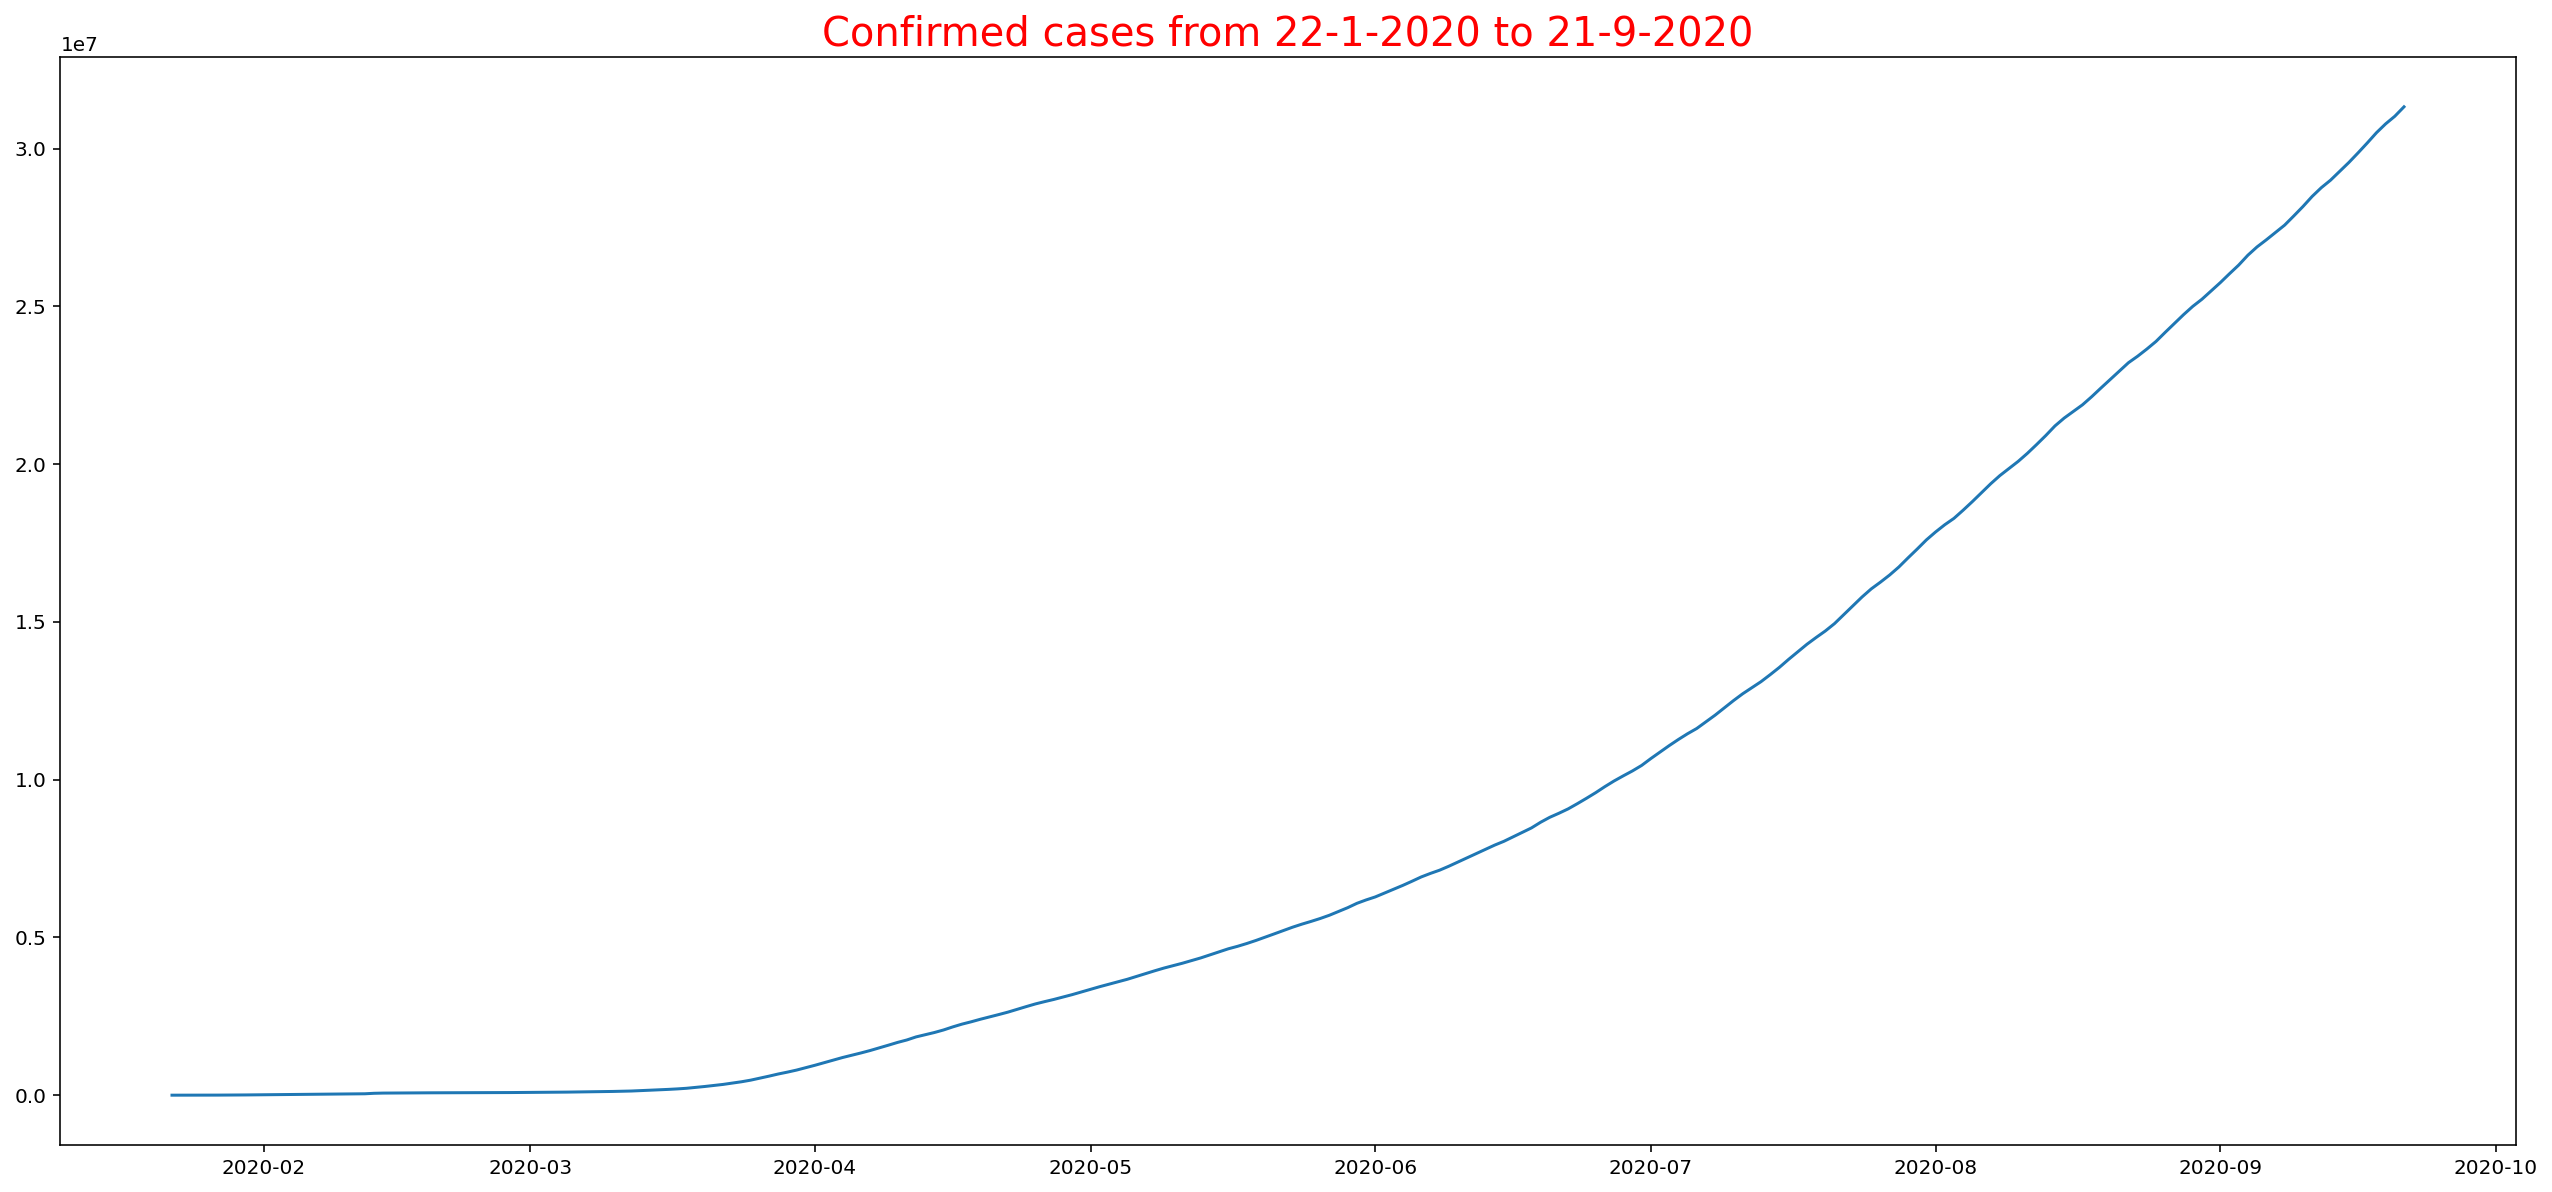

In [82]:
plotting = plt.plot(confirmed_cases)
plt.title('Confirmed cases from 22-1-2020 to 21-9-2020', fontsize = 20, color = 'red')

In [83]:
confirmed_cases = confirmed_cases.diff().fillna(confirmed_cases[0]).astype('int64')
confirmed_cases.head()

2020-01-22    555
2020-01-23     99
2020-01-24    287
2020-01-25    493
2020-01-26    684
dtype: int64

Text(0.5, 1.0, 'Confirmed cases from 22-1-2020 to 21-9-2020')

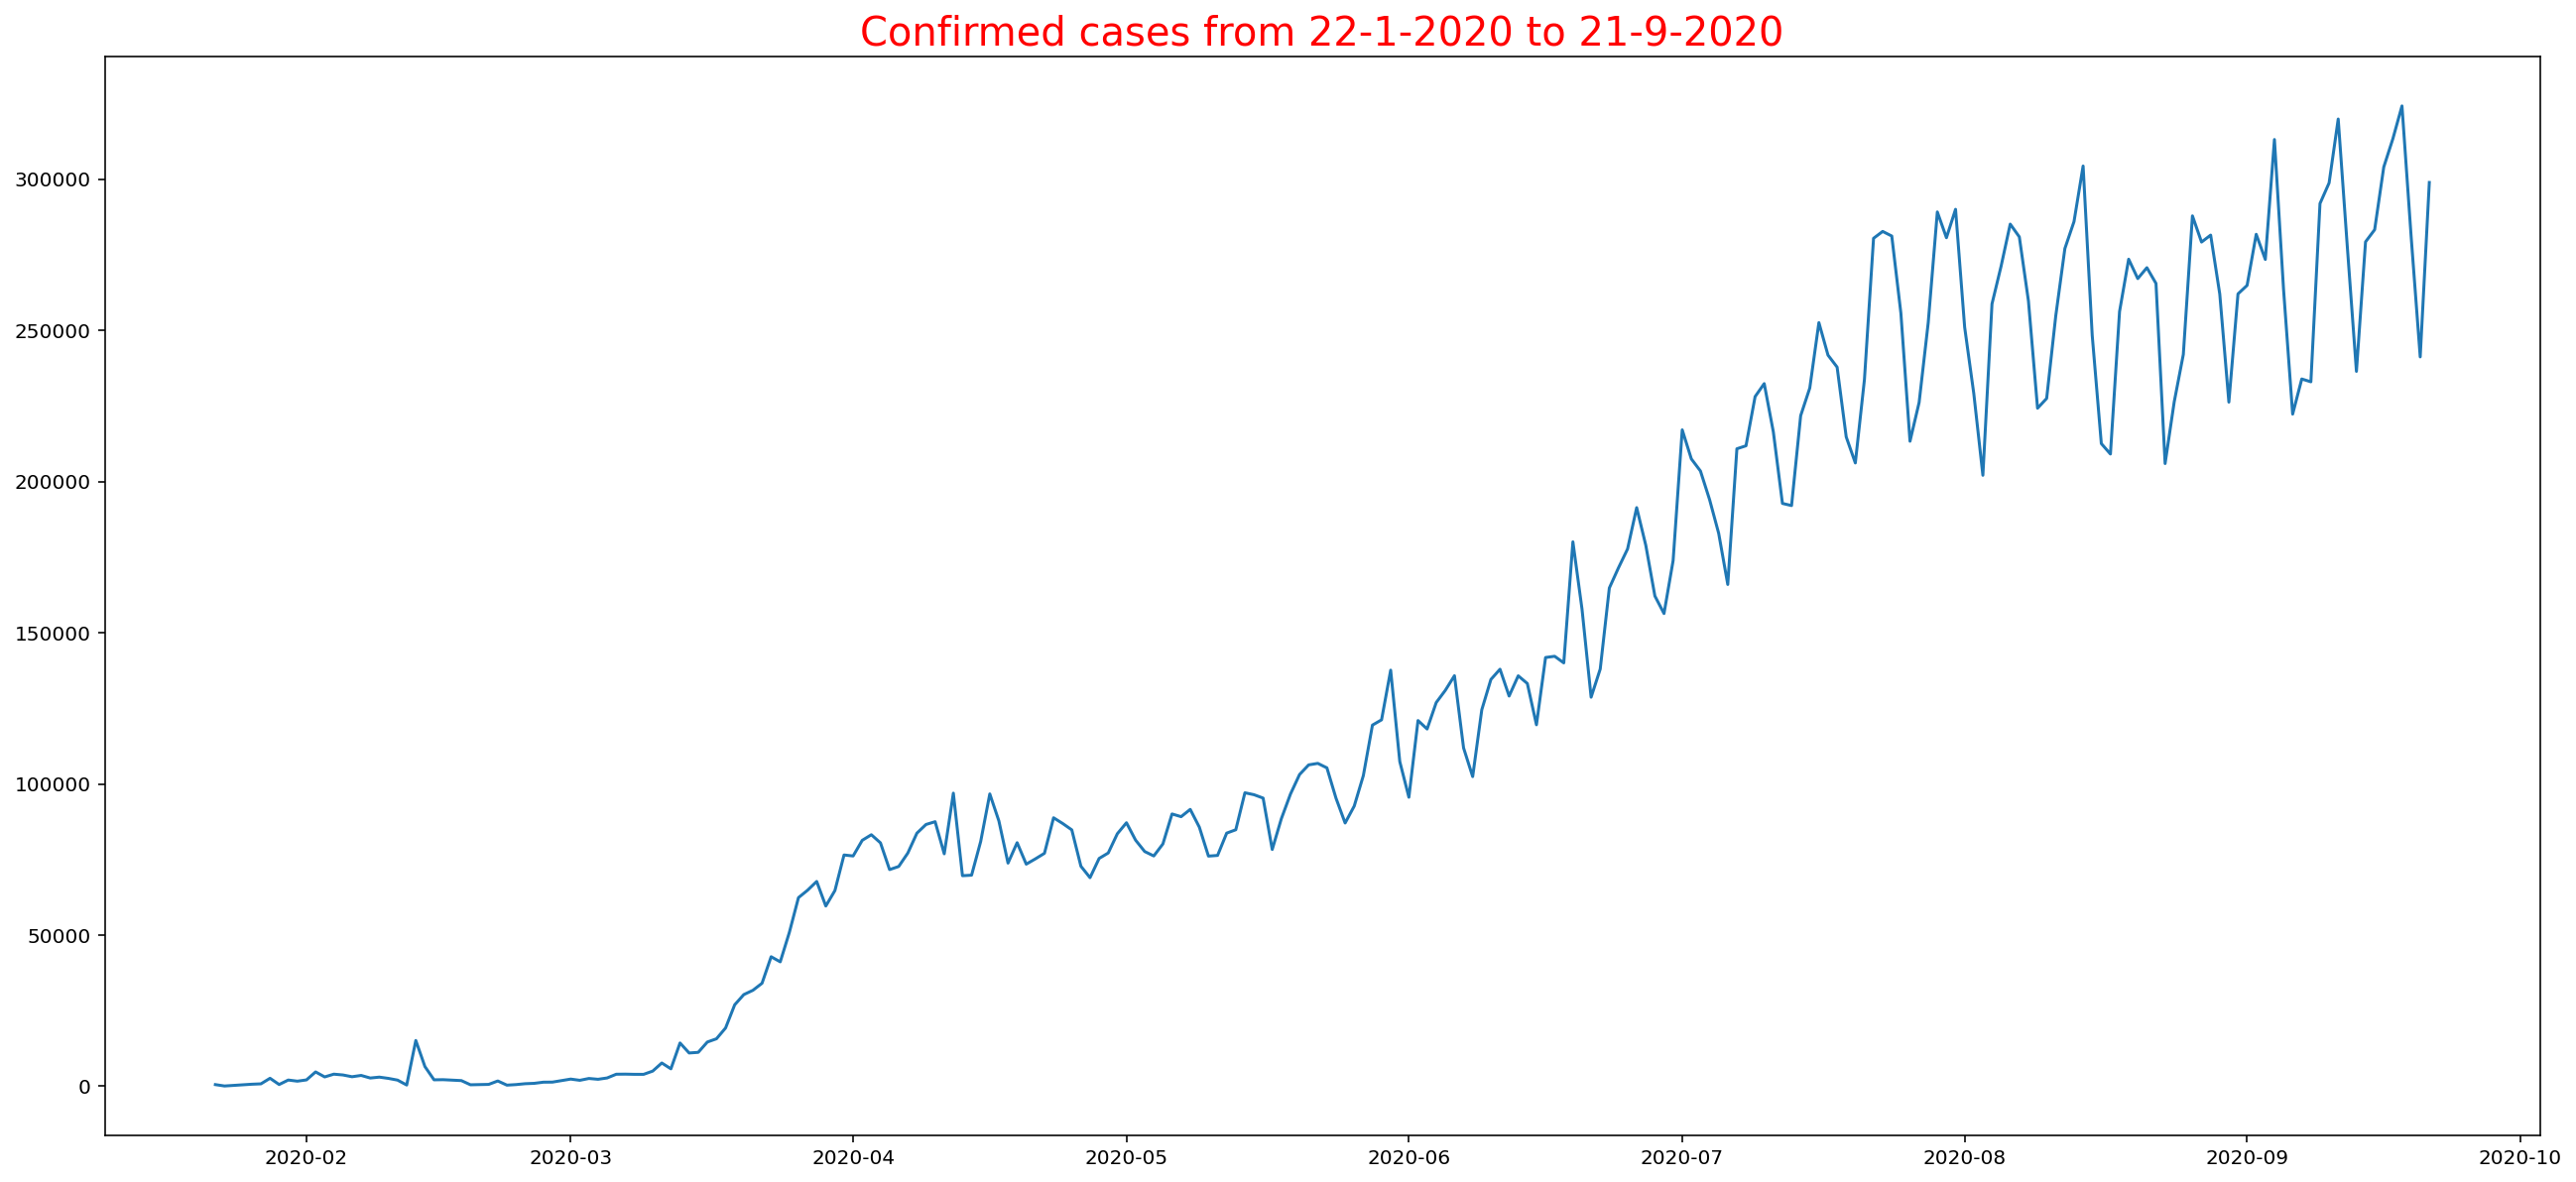

In [84]:
plt.plot(confirmed_cases)
plt.title('Confirmed cases from 22-1-2020 to 21-9-2020', fontsize = 20, color = 'red')

In [85]:
print('Number of days: ', confirmed_cases.shape)

Number of days:  (244,)


In [86]:
train_data = confirmed_cases[:200]
test_data = confirmed_cases[200:]

print('Train data: ', train_data.shape)
print('Test data: ', test_data.shape)

Train data:  (200,)
Test data:  (44,)


In [87]:
# Scaling data with MinMaxScaler
train_fit = np.expand_dims(train_data, axis = 1)
test_fit = np.expand_dims(test_data, axis = 1)

scaler = MinMaxScaler().fit(train_fit)
train_data = scaler.transform(train_fit)
test_data = scaler.transform(test_fit)


In [88]:
print('Train_data: ',train_data.shape)
print('Test_data: ', test_data.shape)

Train_data:  (200, 1)
Test_data:  (44, 1)


In [89]:
# contain "seq_len" data points of history in every data points
def add_history(data, seq_len):
    x_list, y_list = [], []

    for i in range(len(data) - seq_len - 1):
        x = data[i: (i + seq_len)]
        y = data[i + seq_len]
        x_list.append(x)
        y_list.append(y)
    
    return np.array(x_list), np.array(y_list)

seq_len = 4
X_train, y_train = add_history(train_data, seq_len)
X_test, y_test = add_history(test_data, seq_len)

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)

X_train:  torch.Size([195, 4, 1])
y_train:  torch.Size([195, 1])


In [90]:
class LSTM_COVID19(nn.Module):
    def __init__(self, features, hidden_size, seq_len, n_layers = 2):
        super(LSTM_COVID19, self).__init__()
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size = features, hidden_size = hidden_size, num_layers = n_layers, dropout = 0.5)
        self.linear = nn.Linear(in_features = hidden_size, out_features = 1)

    def create_new_hidden_state(self): # stateless LSTM
        self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.hidden_size), 
                       torch.zeros(self.n_layers, self.seq_len, self.hidden_size))

    def forward(self, seq): 
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(seq), self.hidden_size)[-1]
        y_pred = self.linear(last_time_step) # pass last time step to linear layer to get prediction
        
        return y_pred

In [91]:
model = LSTM_COVID19(features = 1, hidden_size = 512, seq_len = seq_len)
criterion = torch.nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
num_epochs = 60
print(model)

LSTM_COVID19(
  (lstm): LSTM(1, 512, num_layers=2, dropout=0.5)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)


In [92]:
def train(model, train_data, train_labels, criterion, optimizer, test_data = None, test_labels = None):
    train_list, test_list = [], []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        model.create_new_hidden_state()

        y_preds = model(train_data)
        loss = criterion(y_preds.float(), train_labels)
        if test_data is not None and test_labels is not None:
            model.eval()
            with torch.no_grad():
                y_test_preds = model(test_data)
                test_loss = criterion(y_test_preds.float(), test_labels)
            test_list.append(test_loss.item())

            if (epoch + 1) % 10 == 0:
                print(f'Epoch: [{epoch+1}/{num_epochs}] | Train Loss: {loss.item()} | Test Loss: {test_loss.item()}')
        train_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return model.eval(), train_list, test_list


In [93]:
%%time
model, train_list, test_list = train(model, X_train, y_train, criterion, optimizer, X_test, y_test)

 15%|█▌        | 9/60 [00:11<01:02,  1.22s/it]

Epoch: [10/60] | Train Loss: 22.92965316772461 | Test Loss: 23.091781616210938


 32%|███▏      | 19/60 [00:23<00:48,  1.19s/it]

Epoch: [20/60] | Train Loss: 15.19180679321289 | Test Loss: 9.889674186706543


 48%|████▊     | 29/60 [00:34<00:37,  1.20s/it]

Epoch: [30/60] | Train Loss: 14.346197128295898 | Test Loss: 11.579925537109375


 65%|██████▌   | 39/60 [00:46<00:25,  1.20s/it]

Epoch: [40/60] | Train Loss: 14.19193172454834 | Test Loss: 12.445484161376953


 82%|████████▏ | 49/60 [00:58<00:13,  1.19s/it]

Epoch: [50/60] | Train Loss: 13.028790473937988 | Test Loss: 8.635611534118652


 98%|█████████▊| 59/60 [01:10<00:01,  1.20s/it]

Epoch: [60/60] | Train Loss: 10.875313758850098 | Test Loss: 7.902181148529053


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]

CPU times: user 1min 10s, sys: 1.88 s, total: 1min 12s
Wall time: 1min 12s


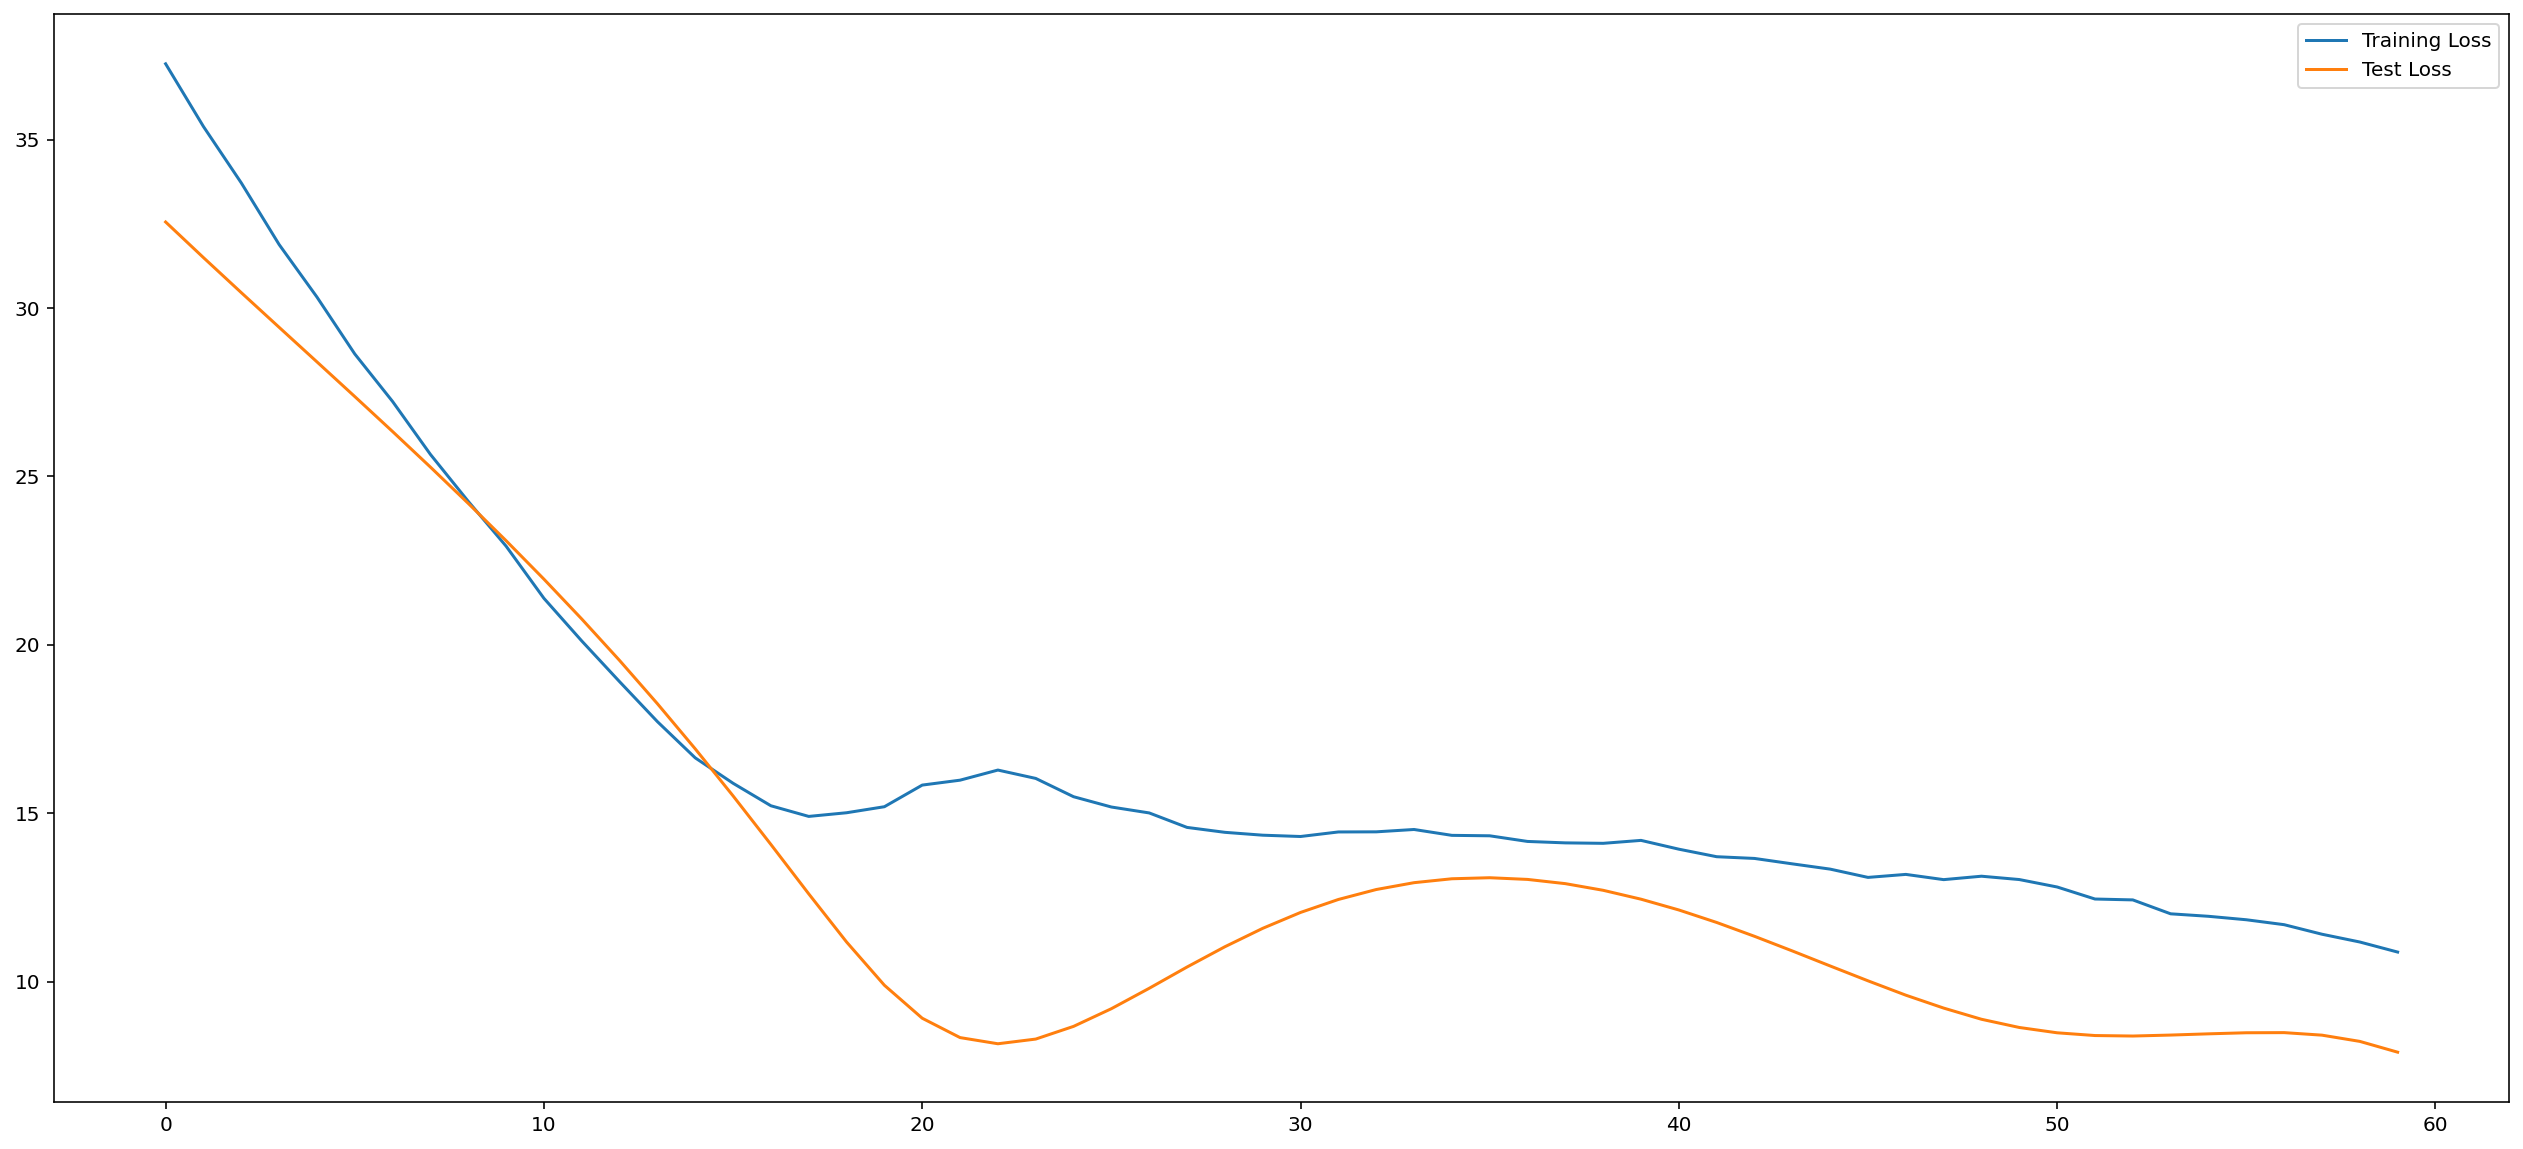

In [94]:
plt.plot(range(num_epochs), train_list, label = 'Training Loss')
plt.plot(range(num_epochs), test_list, label = 'Test Loss')
plt.legend()

In [95]:
with torch.no_grad():
    test_seq = X_test[: 1]
    print(test_seq.shape)
    pred_list = []
    for _ in range(len(X_test)):
        y_test_preds = model(test_seq)
        print('y_test_preds: ', y_test_preds)
        pred = torch.flatten(y_test_preds).item()
        print('pred: ', pred)
        pred_list.append(pred)
        new_seq = test_seq.numpy().flatten()
        print('new_seq flatten: ',new_seq)
        new_seq = np.append(new_seq, [pred])
        print('new_seq append: ', new_seq)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_len, 1).float()

print('Pred list: ', pred_list)

torch.Size([1, 4, 1])
y_test_preds:  tensor([[0.5118]])
pred:  0.5117925405502319
new_seq flatten:  [0.77310246 0.7842704  0.8785633  0.9552696 ]
new_seq append:  [0.77310246 0.78427041 0.87856328 0.95526958 0.51179254]
y_test_preds:  tensor([[0.5029]])
pred:  0.5028507709503174
new_seq flatten:  [0.7842704  0.8785633  0.9552696  0.51179254]
new_seq append:  [0.78427041 0.87856328 0.95526958 0.51179254 0.50285077]
y_test_preds:  tensor([[0.4854]])
pred:  0.48536229133605957
new_seq flatten:  [0.8785633  0.9552696  0.51179254 0.5028508 ]
new_seq append:  [0.87856328 0.95526958 0.51179254 0.50285077 0.48536229]
y_test_preds:  tensor([[0.4629]])
pred:  0.46290555596351624
new_seq flatten:  [0.9552696  0.51179254 0.5028508  0.4853623 ]
new_seq append:  [0.95526958 0.51179254 0.50285077 0.48536229 0.46290556]
y_test_preds:  tensor([[0.4382]])
pred:  0.4382140636444092
new_seq flatten:  [0.51179254 0.5028508  0.4853623  0.46290556]
new_seq append:  [0.51179254 0.50285077 0.48536229 0.4629055

In [96]:
true_cases = scaler.inverse_transform(np.expand_dims(y_test.flatten().numpy(), axis = 0)).flatten()
pred_cases = scaler.inverse_transform(np.expand_dims(pred_list, axis = 0)).flatten()


In [97]:
print(len(y_test))
print(len(pred_list))

39
39


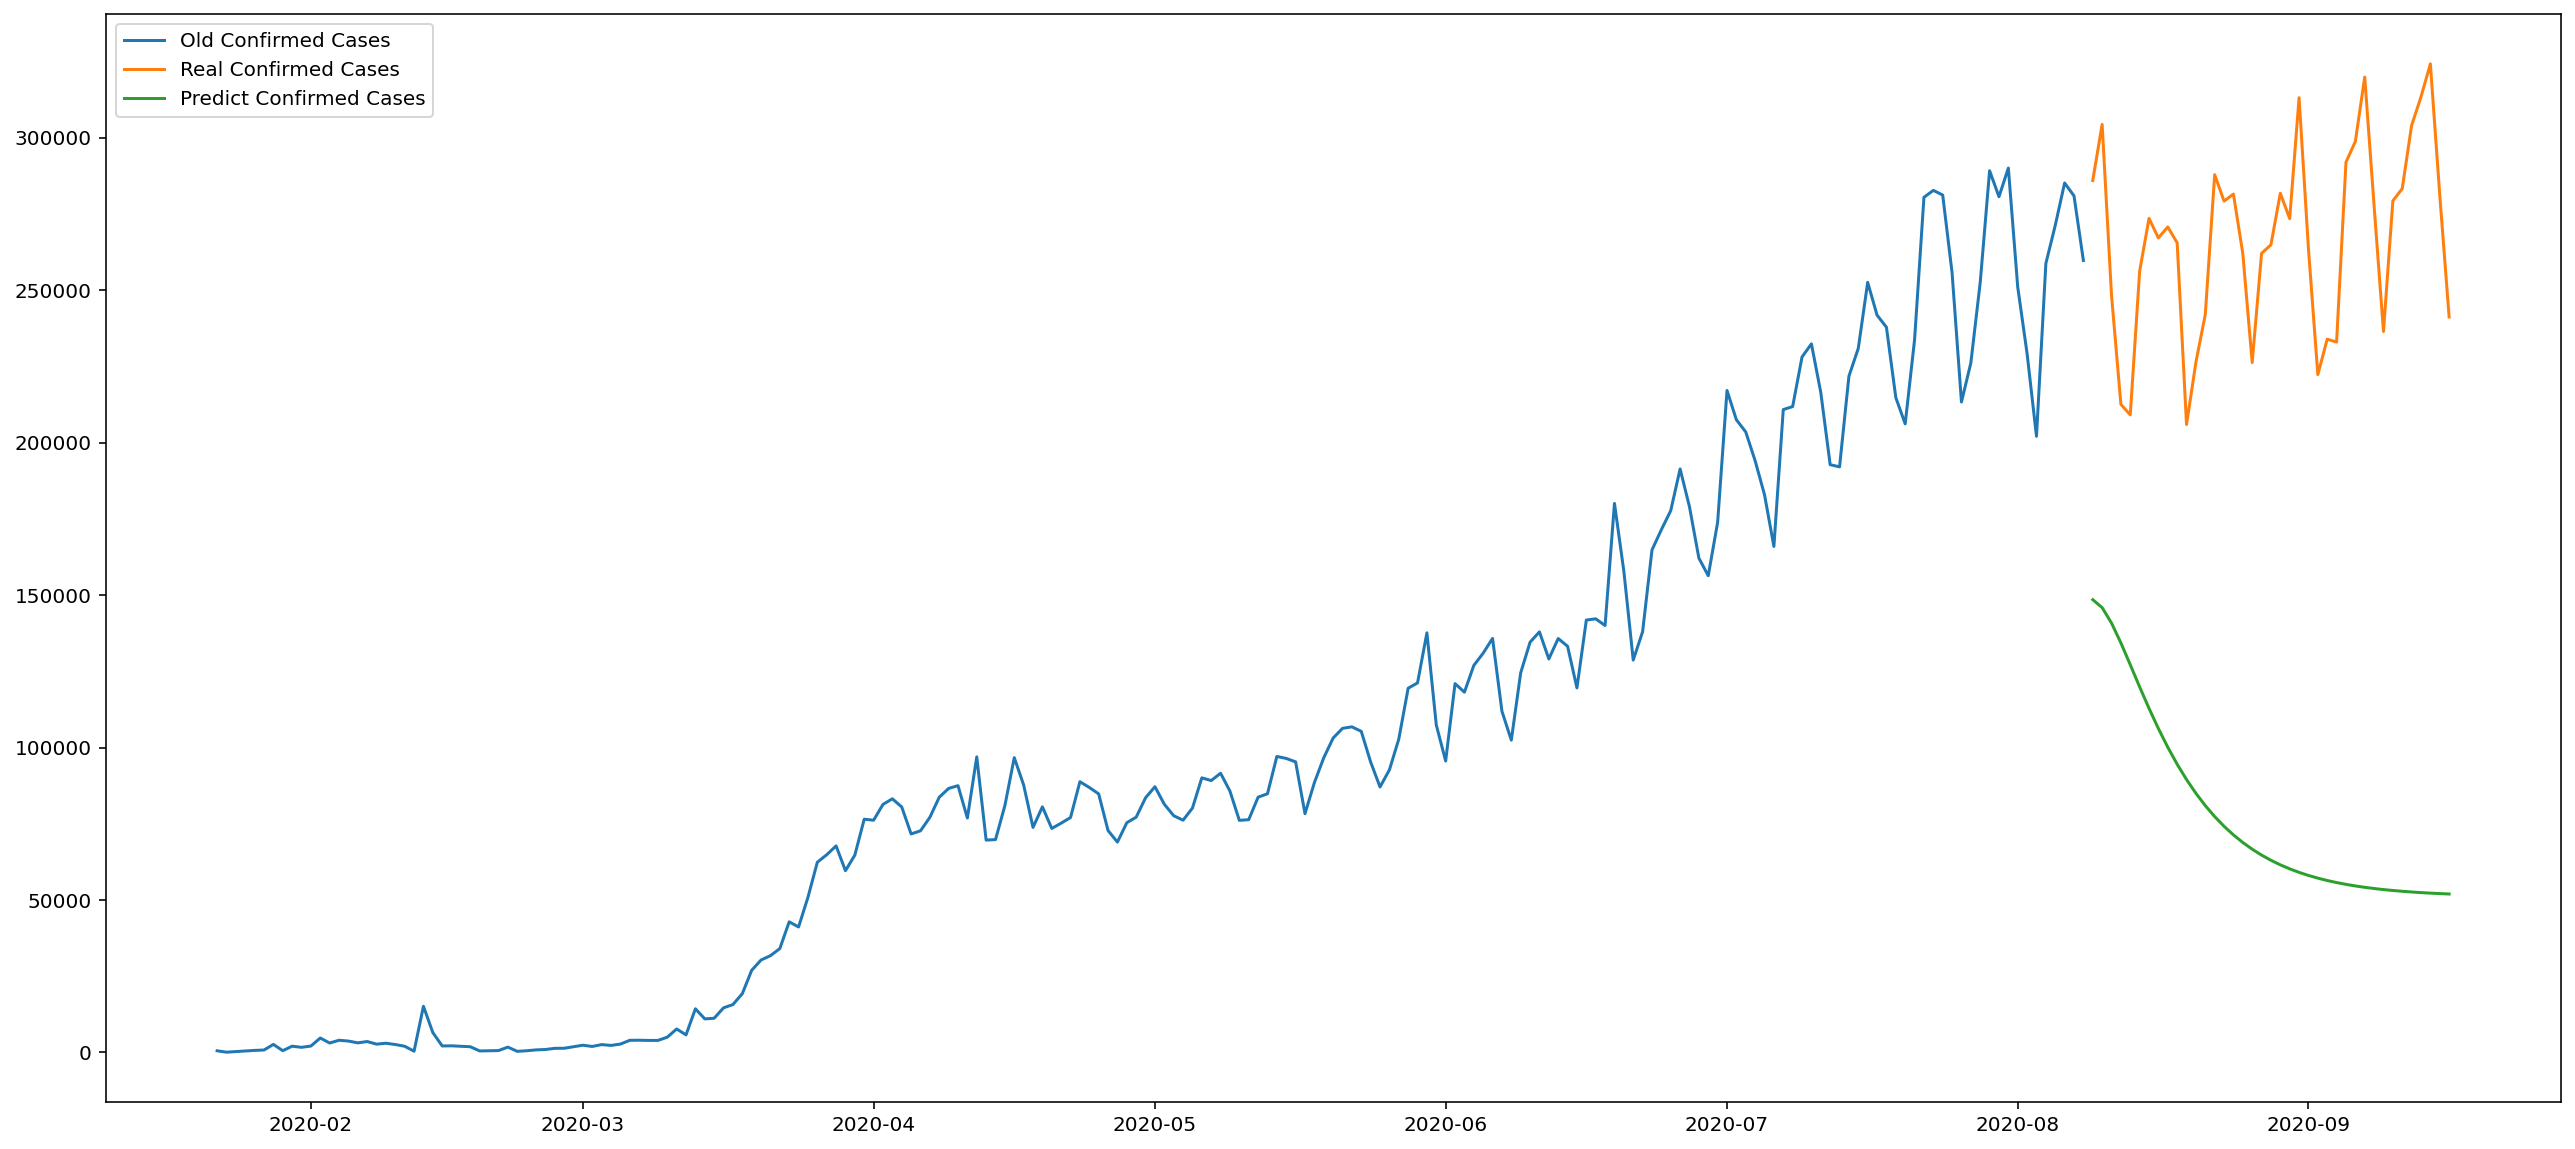

In [98]:
plt.plot(confirmed_cases.index[:len(train_data)], scaler.inverse_transform(train_data).flatten(), label = 'Old Confirmed Cases')
plt.plot(confirmed_cases.index[len(train_data):len(train_data) + len(true_cases)], true_cases, label = 'Real Confirmed Cases')
plt.plot(confirmed_cases.index[len(train_data):len(train_data) + len(pred_cases)], pred_cases, label = 'Predict Confirmed Cases')
plt.legend()